In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from tensorflow.keras import backend as K

from utils.data import load_capg_data, CapgDBName, LoadMode

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
K.set_session(session)  # set this TensorFlow session as the default session for Keras

In [4]:
# set const values
weights_file = './models/capg_mlp_weights.h5'
model_file = './models/capg_mlp_model.h5'

BATCH_SIZE = 128
test_splite = 0.01

In [5]:
# load capg dba data
x_train, y_train, category = load_capg_data(CapgDBName.dba, LoadMode.flat)
y_train = utils.to_categorical(y_train - 1, category)

index = np.random.choice(x_train.shape[0], int(x_train.shape[0]*test_splite))
x_test = x_train[index]
y_test = y_train[index]

x_train = np.delete(x_train, index, axis=0)
y_train = np.delete(y_train, index, axis=0)

print('train set')
print(x_train.shape)
print(y_train.shape)
print('test set')
print(x_test.shape)
print(y_test.shape)

train set
(1425676, 128)
(1425676, 8)
test set
(14400, 128)
(14400, 8)


In [6]:
model = Sequential()

model.add(Dense(256, input_dim=128, name='dense_1'))
model.add(BatchNormalization(momentum=0.9, name='bn_1'))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2, name='dp_1'))

model.add(Dense(256, name='dense_2'))
model.add(BatchNormalization(momentum=0.9, name='bn_2'))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2, name='dp_2'))

model.add(Dense(256, name='dense_3'))
model.add(BatchNormalization(momentum=0.9, name='bn_3'))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2, name='dp_3'))

model.add(Dense(8, activation='softmax', name='output'))

if os.path.exists(model_file):
    print('load weights from a trained model')
    model.load_weights(model_file, by_name=True)
else:
    print('train a new model')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
train a new model


In [7]:
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
bn_1 (BatchNormalizationV1)  (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dp_1 (Dropout)               (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
bn_2 (BatchNormalizationV1)  (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
__________

In [8]:
# tb_callback = TensorBoard(log_dir='./logs/mlp/',
#                           histogram_freq=1,
#                           batch_size=32,
#                           write_grads=True,
#                           update_freq='batch')

In [9]:
def learning_rate_tuner(epoch):
    lr = 0.1
    if 30 <= epoch < 60:
        lr = 0.01
    elif epoch >= 60:
        lr = 0.001
    return lr

lr_scheduler = LearningRateScheduler(learning_rate_tuner)

In [10]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=100,
                    validation_data=(x_test, y_test), callbacks=[lr_scheduler])

Train on 1425676 samples, validate on 14400 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1425676/1425676 [==============================] - 28s 19us/sample - loss: 1.6531 - acc: 0.3458 - val_loss: 1.3296 - val_acc: 0.4790
Epoch 2/100
1425676/1425676 [==============================] - 27s 19us/sample - loss: 1.4256 - acc: 0.4439 - val_loss: 1.1664 - val_acc: 0.5537
Epoch 3/100
 967552/1425676 [===================>..........] - ETA: 8s - loss: 1.3290 - acc: 0.4863

KeyboardInterrupt: 

In [9]:
model.save_weights(weights_file)
model.save(model_file)
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


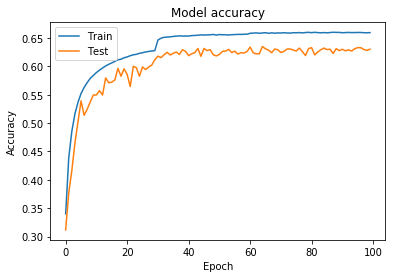

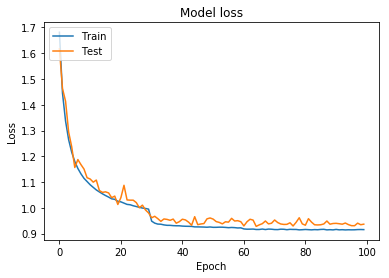

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('./figures/mlp_acc.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('./figures/mlp_loss.png')
plt.show()